In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from nltk.corpus import stopwords
import nltk
import math
import time
import itertools
import joblib
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from PIL import Image
import requests
from io import BytesIO
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

<ul>    
    <li><h3>Loading dataset</h3></li>
    <li><h3>Number of rows and columns</h3></li>
</ul>    

In [2]:
# Loading the dataset which contains all the details of the product
data = pd.read_json("Dataset1.json")
data.replace("null", value=np.nan, inplace=True)

In [3]:
# Total no of rows and columns
print('Total no of data points: ', len(data.index))
print('Total no of features: ', len(data.columns))

Total no of data points:  183138
Total no of features:  7


In [4]:
# There are 7 features of every item
data.columns

Index(['asin', 'brand', 'color', 'medium_image_url', 'product_type_name',
       'title', 'formatted_price'],
      dtype='object')

<h2>Examining missing data of all features</h2>

<ul>
    <li><h3>Exploring feature: product_type_name</h3></li>
</ul>

In [5]:
# This feature describes the type of the products
# There are 72 unique product type
# Out of 183138 products in the dataset 167794 are shirts
# This feature has no missing values
data['product_type_name'].describe()

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object

In [6]:
# Percentage of products which are of type shirt
# 91.62% of the product are shirt
x = data['product_type_name'].describe().freq
y = len(data.index)
percent_of_shirt = (x/y) * 100
percent_of_shirt

91.62161867007393

In [7]:
# 10 most frequent product type
data.groupby(['product_type_name']).agg({'product_type_name':'count'}).nlargest(10, 'product_type_name')

,product_type_name
product_type_name,
SHIRT,167794
APPAREL,3549
BOOKS_1973_AND_LATER,3336
DRESS,1584
SPORTING_GOODS,1281
SWEATER,837
OUTERWEAR,796
OUTDOOR_RECREATION_PRODUCT,729
ACCESSORY,636


<ul>
    <li><h3>Exploring feature: brand</h3></li>
</ul>

In [8]:
# This feature represents the brand of the product
# There are 10578 unique brand in the data
# Most number of brands present in the data is 'Zago'
# There are 151 missing values in this feature (183138 - 182987 = 151)
data['brand'].describe()

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object

In [9]:
# 10 most frequent occuring brand
data.groupby(['brand']).agg({'brand':'count'}).nlargest(10, 'brand')

,brand
brand,
Zago,223
XQS,222
Yayun,215
YUNY,198
XiaoTianXin-women clothes,193
Generic,192
Boohoo,190
Alion,188
Abetteric,187


<ul>
    <li><h3>Exploring feature: color</h3></li>
</ul>

In [10]:
# This feature represents color of the product
# There are 7379 unique color
# Black is the most common color
# There are 118187 missing values in color column
data['color'].describe()

count     64951
unique     7379
top       Black
freq      13207
Name: color, dtype: object

In [11]:
# 10 most frequent color
data.groupby(['color']).agg({'color':'count'}).nlargest(10, 'color')

,color
color,
Black,13207
White,8616
Blue,3570
Red,2289
Pink,1842
Grey,1499
*,1388
Green,1258
Multi,1203


<ul>
    <li><h3>Exploring feature: formatted_price</h3></li>
</ul>

In [12]:
# This feature represents the price of the product
# There are 3135 unique price 
# There 154743 missing values in price column
data['formatted_price'].describe()

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

In [13]:
# 10 most frequent price value
data.groupby(['formatted_price']).agg({'formatted_price':'count'}).nlargest(10, 'formatted_price')

,formatted_price
formatted_price,
$19.99,945
$9.99,749
$9.50,601
$14.99,472
$7.50,463
$24.99,414
$29.99,370
$8.99,343
$9.01,336


<ul>
    <li><h3>Exploring feature: Title</h3></li>
</ul>

In [14]:
# This feature represents the title of the product
# There are 175985 unique feature
# There are no missing values in title column
# This will be our primary feature
data['title'].describe()

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object

<h2> Removing duplicate in title column.</h2>

In [15]:
# Examining Title field
# No. of duplicates 
sum(data.duplicated('title'))

7153

In [16]:
def filter_title(title):
    return len(title.split())>4

In [17]:
# Title with less than 4 words are removed 
data_sorted = data[data['title'].apply(lambda x: filter_title(x))]


In [18]:
# Sorting the data according to title
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
27547,B073W7P8KK,Nation LTD,Blue,https://images-na.ssl-images-amazon.com/images...,DRESS,❀Nation Women Stripe Blouse Long Sleeve Shirt ...,NaN
31277,B01M0PWMZ8,Anglin,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,✽ANGLIN✽ Women Striped Floral Long Sleeve Roun...,NaN
30453,B01M02GWRG,Anglin,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,✽ANGLIN✽ Women Striped Floral Long Sleeve Roun...,NaN
32485,B01N0ADXM0,Anglin,Red,https://images-na.ssl-images-amazon.com/images...,SHIRT,✽ANGLIN✽ Women Fashion Stripe Dress Round Coll...,NaN
26767,B01MTQAU86,Anglin,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,✽ANGLIN✽ Women Autumn Winter Christmas Printin...,NaN


In [55]:
# Storing the indices of the sorted dataset in a list
index_list = []
for index,row in data_sorted.iterrows():
    index_list.append(index)

In [56]:
# Declaring two variables i and j for looping through the sorted dataset
i = 0
j = 0
# Creating a list which will contain the asin of unique titles
asins_dedup = []

# Storing number of rows in a variable
numOfRows = data_sorted.shape[0]

# Starting a loop which iterates through the datapoints
while i < numOfRows and j < numOfRows:
    
    current_i = i
    
    # Extracting the title and converting it into a list of words
    r1 = data['title'].loc[index_list[i]].split()
    
    # Starting another loop from the title at i+1 index 
    j = i+1
    while j < numOfRows:
        
        # Extracting the title at index j and converting it into list of words
        r2 = data['title'].loc[index_list[j]].split()
        
        # store the length of the title which is maximum
        length = max(len(r1), len(r2))

        count  = 0
        
        # Using zip_longest to extract each word alternatively from each title and store it in tuple
        # It will store None if the length of the title are unequal
        # Example: n1 = [1,2,3,4,5]
        #          n2 = [1,2,3]
        # itertools.zip_longest will give: [(1,1), (2,2), (3,3), (4,None), (5,None)]          
        # Storing the number of words similar in count
        for l in itertools.zip_longest(r1,r2): 
            if (l[0] == l[1]):
                count += 1
        
        # The difference between the length and count represents the number of words which are different in 2 titles.
        # If the number of words which differ are more than 2, then it is declared the 2 titles are not same, hence the asins is stored in the list.
        # If it is less than two then iterate to the next title and compare
        if (length - count) > 2: 
            asins_dedup.append(data_sorted['asin'].loc[index_list[i]])
            i = j
            break
        else:
            j += 1
    if current_i == i:
        break

In [57]:
# Storing the deduped in the data variable
data = data.loc[data['asin'].isin(asins_dedup)]

In [58]:
# The number of datapoints are decreased to 151251
print('Number of data points : ', data.shape[0])

Number of data points :  151251


In [59]:
# reseting the index
data.reset_index(inplace=True)


In [60]:
data

,index,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,0,B016I2TS4W,FNC7C,NaN,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,NaN
1,3,B01N19U5H5,Focal18,NaN,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,NaN
2,4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
3,5,B00TAEHGGS,Fitscloth,Grape,https://images-na.ssl-images-amazon.com/images...,SHIRT,[Fits Cloth] Grape Solid Modern Long Sleeve Pl...,NaN
4,6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
...,...,...,...,...,...,...,...,...
151246,183131,B071V9D3MH,Jingjing1,NaN,https://images-na.ssl-images-amazon.com/images...,SHIRT,"Women's Cold Shoulder Button Down Shirt, Long ...",NaN
151247,183132,B074GSTF5S,Ulla Popken,NaN,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ulla Popken Women's Plus Size Crochet Lace Acc...,NaN
151248,183134,B015W98YQK,VOGUE CODE,Monochrome Plaid,https://images-na.ssl-images-amazon.com/images...,SHIRT,VOGUE CODE Vintage V Neck Plaid Shirt Sleevele...,NaN
151249,183135,B075756PGC,Wrangler,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Wrangler George Strait For Her Long Sleeve Pin...,NaN


<h2> NLP Preprocessing</h2>

In [ ]:
#Using the list of stopwords from nltk package
list_of_stopwords = set(stopwords.words('english'))
print ('Stopwords:', list_of_stopwords)

In [61]:
# Basic preprocessing of the title text
def preprocessing(title, index, column):
    # If the title is numeric then it is not preprocessed
    if type(title) is not int:
        text = ""
        # Iterating each word in title
        for words in title.split():
            # remove the special chars in 
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in list_of_stopwords:
                text += word + " "
        data[column][index] = text

Stopwords: {'after', 'not', 'couldn', 'own', 'ours', 'aren', 's', 'both', "mustn't", "wasn't", 'haven', "doesn't", 'ain', 'again', 'while', 'but', "it's", 'into', "hasn't", "hadn't", 'are', 'his', 'ma', 'weren', 'there', 'they', 'does', 'had', "haven't", 'theirs', 'during', 'have', 've', 'didn', "couldn't", 'an', 'our', 'with', "isn't", 'very', 'me', 'too', 'so', 'off', "don't", 'it', 'herself', 'isn', 'above', 'if', 'o', 'd', 'll', "shouldn't", 'he', 'here', 'hadn', 'shan', "she's", 'no', 'mustn', 'that', 'by', 'until', 'as', 'wouldn', 'yourselves', 'ourselves', "wouldn't", 'of', "should've", 'because', 'did', 'once', "mightn't", 'won', 'been', 'my', 'doesn', 'this', 'shouldn', 'himself', 'over', "you're", 'mightn', 'those', 'some', 'out', 'the', 'were', 'only', 'be', 'has', 'why', 'their', 'each', 'nor', 'most', 'just', 'such', 'for', 'a', "that'll", "you'd", 'its', 'which', 'all', 'she', 'needn', 'between', 'from', 'these', 'being', "needn't", 'hasn', 'more', 'how', 'about', 'her', 

In [62]:
start = time.process_time()
for index, row in data.iterrows():
    preprocessing(row['title'], index, 'title')
print(time.process_time() - start)    

410.171875


In [63]:
data.to_pickle('Dataset1_data_preprocessed')

In [64]:
data = pd.read_pickle('Dataset1_data_preprocessed')
data

,index,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,0,B016I2TS4W,FNC7C,NaN,https://images-na.ssl-images-amazon.com/images...,SHIRT,minions como superheroes ironman long sleeve r...,NaN
1,3,B01N19U5H5,Focal18,NaN,https://images-na.ssl-images-amazon.com/images...,SHIRT,focal18 sailor collar bubble sleeve blouse shi...,NaN
2,4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
3,5,B00TAEHGGS,Fitscloth,Grape,https://images-na.ssl-images-amazon.com/images...,SHIRT,fits cloth grape solid modern long sleeve plai...,NaN
4,6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
...,...,...,...,...,...,...,...,...
151246,183131,B071V9D3MH,Jingjing1,NaN,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens cold shoulder button shirt long sleeve ...,NaN
151247,183132,B074GSTF5S,Ulla Popken,NaN,https://images-na.ssl-images-amazon.com/images...,SHIRT,ulla popken womens plus size crochet lace acce...,NaN
151248,183134,B015W98YQK,VOGUE CODE,Monochrome Plaid,https://images-na.ssl-images-amazon.com/images...,SHIRT,vogue code vintage v neck plaid shirt sleevele...,NaN
151249,183135,B075756PGC,Wrangler,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,wrangler george strait long sleeve pink print ...,NaN


<h2> Removing data points whose image url is not opening</h2>

In [ ]:
import sys
def display_img_s(url):
    
    try:
        # we get the url of the apparel and download it
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        # we will display it in notebook 
        return False
    except:
        return True
        

In [ ]:
for i in range(len(data['medium_image_url'])):
    if display_img_s(data['medium_image_url'][i]):
        data.drop(i, inplace=True)
            

In [ ]:
data.to_pickle('Dataset1')

In [3]:
data = pd.read_pickle('Dataset1')
data.reset_index(inplace=True, drop=True)
data.drop(['index'],axis = 1, inplace=True)

In [4]:
data

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,null,https://images-na.ssl-images-amazon.com/images...,SHIRT,minions como superheroes ironman long sleeve r...,null
1,B01N19U5H5,Focal18,null,https://images-na.ssl-images-amazon.com/images...,SHIRT,focal18 sailor collar bubble sleeve blouse shi...,null
2,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
3,B00TAEHGGS,Fitscloth,Grape,https://images-na.ssl-images-amazon.com/images...,SHIRT,fits cloth grape solid modern long sleeve plai...,null
4,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
...,...,...,...,...,...,...,...
142008,B071V9D3MH,Jingjing1,null,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens cold shoulder button shirt long sleeve ...,null
142009,B074GSTF5S,Ulla Popken,null,https://images-na.ssl-images-amazon.com/images...,SHIRT,ulla popken womens plus size crochet lace acce...,null
142010,B015W98YQK,VOGUE CODE,Monochrome Plaid,https://images-na.ssl-images-amazon.com/images...,SHIRT,vogue code vintage v neck plaid shirt sleevele...,null
142011,B075756PGC,Wrangler,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,wrangler george strait long sleeve pink print ...,null


<h2>Utility Functions</h2>

In [5]:


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def get_result(url):
        

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(1, 1) 
        fig = plt.figure(figsize=(25,3))
        
        ax = plt.subplot(gs[0])
        
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    

<h2>NLP Models</h2>

<ul>
    <li><h3>Bag Of Word Model</h3></li>
</ul>

In [6]:
# Converting the each title into a vector which records the number of times the word occur in the title
# The length of the vector equals the number of unique words present in all of the titles in the dataset
# CountVectorizer is used to convert each titles into vector
# After fitting the title in CountVectorizer model, it returns a csr matrix which stores only non zero elements
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
word_matrix   = count_vectorizer.fit_transform(data['title'])
word_matrix.get_shape()

(142013, 41286)

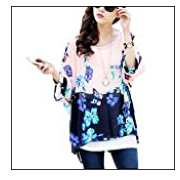

ASIN : B012SXRBVC
Brand: Bao Core
Title: bao core womens floral semi sheer batwing loose blouse bohemian oversized shirt 
Euclidean similarity with the query image : 0.0


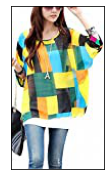

ASIN : B01HOBRHH6
Brand: JLTPH
Title: jltph women batwing chiffon shirt bohemian floral semi sheer loose blouse tunic tops 
Euclidean similarity with the query image : 3.0


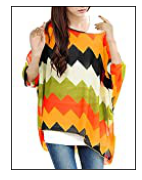

ASIN : B01HOCYP7U
Brand: JLTPH
Title: jltph ladies batwing chiffon shirt bohemian semi sheer loose floral blouse tunic tops 
Euclidean similarity with the query image : 3.0


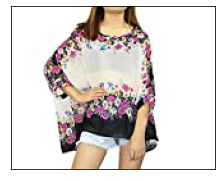

ASIN : B072PR1DPZ
Brand: Einskey
Title: womens batwing sleeve chiffon bohemian beach loose shirt floral blouse tunic tops 
Euclidean similarity with the query image : 3.1622776601683795


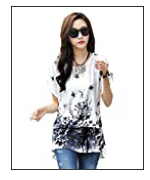

ASIN : B01F8K8ATY
Brand: Buy-Box
Title: buybox womens exotic batwing sleeve shirt bohemian floral prints tops oversized blouse 
Euclidean similarity with the query image : 3.1622776601683795


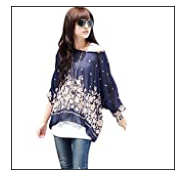

ASIN : B00RF39HGI
Brand: Lowpricenice
Title: dayseventh lady batwing sleeve chiffon shirt bohemian floral oversized blouse 
Euclidean similarity with the query image : 3.1622776601683795


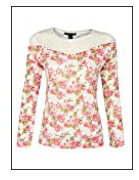

ASIN : B074J5SFVW
Brand: SWISSWELL
Title: womens shirts lace floral loose blouse 
Euclidean similarity with the query image : 3.1622776601683795


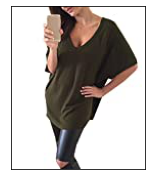

ASIN : B01N8SKBBS
Brand: Fairviewer
Title: womens short batwing sleeve loose shirt blouse top 
Euclidean similarity with the query image : 3.1622776601683795


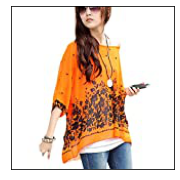

ASIN : B00RF2Y1EW
Brand: Lowpricenice
Title: lowpricenice sexy womens batwing sleeve bohemian oversized blouse 
Euclidean similarity with the query image : 3.1622776601683795


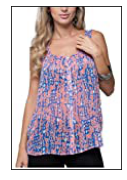

ASIN : B00EJVXIYG
Brand: SurelyMine
Title: surelymine womens floral sheer sleeveless blouse 
Euclidean similarity with the query image : 3.1622776601683795


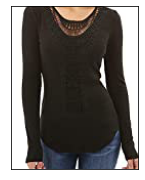

ASIN : B0746CPRSY
Brand: Faithtur
Title: womens hollow floral lace sheer shirt blouse top 
Euclidean similarity with the query image : 3.1622776601683795


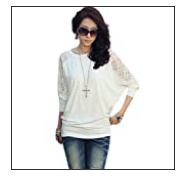

ASIN : B00OUENL62
Brand: Huawen
Title: womens batwing dolman loose blouse shirt lace shirt 
Euclidean similarity with the query image : 3.1622776601683795


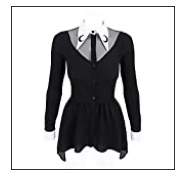

ASIN : B01HVD3DIY
Brand: RE Style
Title: luna shirt  womens blouse 
Euclidean similarity with the query image : 3.1622776601683795


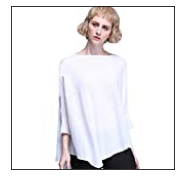

ASIN : B06W2J1RKX
Brand: Modishou
Title: modishou womens new batwing irregular loose shirt blouse 
Euclidean similarity with the query image : 3.1622776601683795


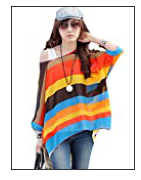

ASIN : B012ND68EI
Brand: Buy-Box
Title: buybox womens batwing dolman sleeve shirt bohemian tops oversized blouse 
Euclidean similarity with the query image : 3.1622776601683795


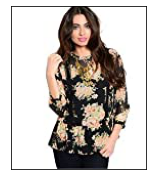

ASIN : B017LB5OWE
Brand: On Twelfth
Title: twelfth womens floral blouse 
Euclidean similarity with the query image : 3.1622776601683795


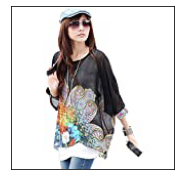

ASIN : B012SDKKII
Brand: Lookatool
Title: lookatool womens batwing sleeve chiffon shirt bohemian tops oversized blouse 
Euclidean similarity with the query image : 3.1622776601683795


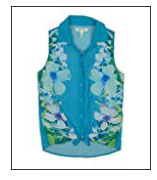

ASIN : B00G20S5TK
Brand: Aeropostale
Title: aeropostale womens sheer floral dolman blouse 
Euclidean similarity with the query image : 3.1622776601683795


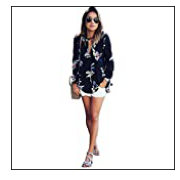

ASIN : B01I9KOXG4
Brand: GONKOMA
Title: gonkoma womens floral printing loose shirt blouse tops 
Euclidean similarity with the query image : 3.1622776601683795


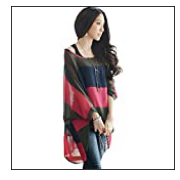

ASIN : B00ZKH66E2
Brand: Shineflow
Title: womens batwing dolman sleeve chiffon bohemian oversized blouse 
Euclidean similarity with the query image : 3.1622776601683795


In [7]:
# This method accepts 2 parameters document index and number of similar products needed
# It calculates the pairwise distance between the vector of query product (doc_index) and vectors of all the titles.
# This pairwise distance is calculated using pairwise_distances function which returns a matrix containing distances of query point with all titles
# This matrix is flattened to numpy array
# The array is then passed to numpy.argsort which returns the indices of distances in ascending order of distances
# The array is then passed to numpy.sort which returns a sorted array of distances in ascending order
# In order to present the results each indices  of sorted distance is passed into get_result function along with image url
# A heat map is printed which represents all the common words between query title. 

def bagOfWords(doc_index, num_of_similar_prod):
    
    pairwise_dist = pairwise_distances(word_matrix, word_matrix[doc_index])
    
    # np.argsort will return indices of the smallest distances
    sorted_indices_of_distance = np.argsort(pairwise_dist.flatten())[0:num_of_similar_prod]
    #pdists will store the smallest distances
    p_distance  = np.sort(pairwise_dist.flatten())[0:num_of_similar_prod]

    
    for i in range(len(sorted_indices_of_distance)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(data['medium_image_url'].loc[sorted_indices_of_distance[i]])
        print('ASIN :',data['asin'].loc[sorted_indices_of_distance[i]])
        print ('Brand:', data['brand'].loc[sorted_indices_of_distance[i]])
        print ('Title:', data['title'].loc[sorted_indices_of_distance[i]])
        print ('Euclidean similarity with the query image :', p_distance[i])
        print('='*60)

bagOfWords(12566, 20) 

  <ul>
    <li><h3>TF-IDF Model</h3></li>
</ul>

In [8]:
# Converting the each title into a vector which records the tf-idf value of the word occur in the title
# The length of the vector equals the number of unique words present in all of the titles in the dataset
# TfidfVectorizer is used to convert each titles into tf-idf vector
# After fitting the title in TfidfVectorizer model, it returns a csr matrix which stores only non zero elements
tfidf_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_word_matrix = tfidf_vectorizer.fit_transform(data['title'])

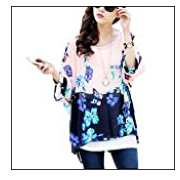

ASIN : B012SXRBVC
Brand: Bao Core
Title: bao core womens floral semi sheer batwing loose blouse bohemian oversized shirt 
Euclidean similarity with the query image : 0.0


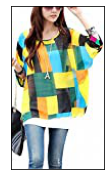

ASIN : B01HOBRHH6
Brand: JLTPH
Title: jltph women batwing chiffon shirt bohemian floral semi sheer loose blouse tunic tops 
Euclidean similarity with the query image : 0.9860505366458812


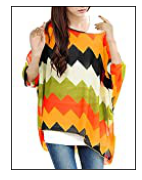

ASIN : B01HOCYP7U
Brand: JLTPH
Title: jltph ladies batwing chiffon shirt bohemian semi sheer loose floral blouse tunic tops 
Euclidean similarity with the query image : 0.9915323617518398


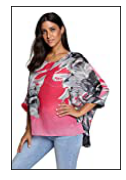

ASIN : B074M7BYBJ
Brand: Nicetage
Title: nicetage bohemian floral chiffon blouse casual batwing blouse hippie semi sheer loose tops 
Euclidean similarity with the query image : 1.0199469059377246


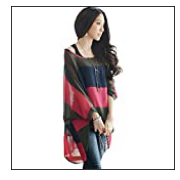

ASIN : B00ZKH66E2
Brand: Shineflow
Title: womens batwing dolman sleeve chiffon bohemian oversized blouse 
Euclidean similarity with the query image : 1.060337977447804


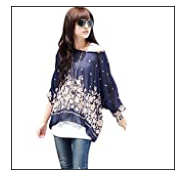

ASIN : B00RF39HGI
Brand: Lowpricenice
Title: dayseventh lady batwing sleeve chiffon shirt bohemian floral oversized blouse 
Euclidean similarity with the query image : 1.0762314968758118


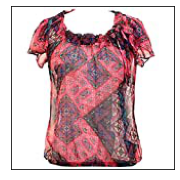

ASIN : B00UWY3FLU
Brand: Luxury Divas
Title: bohemian style multicolor print semi sheer top 
Euclidean similarity with the query image : 1.0767563732593355


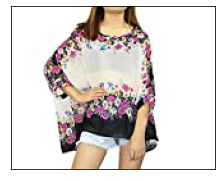

ASIN : B072PR1DPZ
Brand: Einskey
Title: womens batwing sleeve chiffon bohemian beach loose shirt floral blouse tunic tops 
Euclidean similarity with the query image : 1.089627271222057


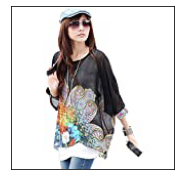

ASIN : B012SDKKII
Brand: Lookatool
Title: lookatool womens batwing sleeve chiffon shirt bohemian tops oversized blouse 
Euclidean similarity with the query image : 1.0910369225970127


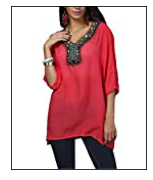

ASIN : B00ZTQGELY
Brand: Kafeimali
Title: kafeimali womens bohemian embroidered loose tops semi sheer shirt mini dress 
Euclidean similarity with the query image : 1.0959946909209586


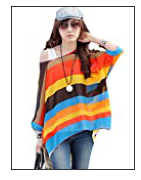

ASIN : B012ND68EI
Brand: Buy-Box
Title: buybox womens batwing dolman sleeve shirt bohemian tops oversized blouse 
Euclidean similarity with the query image : 1.1058223579929805


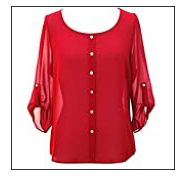

ASIN : B00UWYVDGY
Brand: Luxury Divas
Title: 34 sleeve semi sheer chiffon blouse 
Euclidean similarity with the query image : 1.1072228038083223


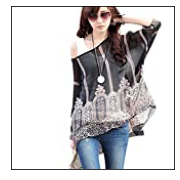

ASIN : B00RF32W7Y
Brand: Lowpricenice
Title: dayseventh vintage women batwing sleeve bohemian oversized blouse 
Euclidean similarity with the query image : 1.1107468237249534


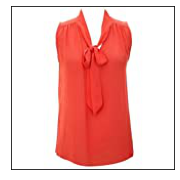

ASIN : B00UWY88QM
Brand: Luxury Divas
Title: semi sheer sleeveless chiffon top 
Euclidean similarity with the query image : 1.1159696673475128


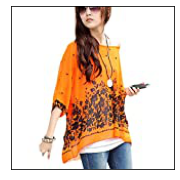

ASIN : B00RF2Y1EW
Brand: Lowpricenice
Title: lowpricenice sexy womens batwing sleeve bohemian oversized blouse 
Euclidean similarity with the query image : 1.1235980562829462


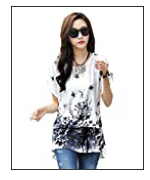

ASIN : B01F8K8ATY
Brand: Buy-Box
Title: buybox womens exotic batwing sleeve shirt bohemian floral prints tops oversized blouse 
Euclidean similarity with the query image : 1.1236460975573714


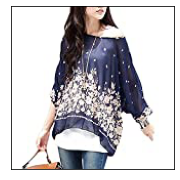

ASIN : B00YCA1YFY
Brand: Display Promotion
Title: womens bohemian floral batwing sleeve plus chiffon oversize loose shoulder blouse 
Euclidean similarity with the query image : 1.125736769418899


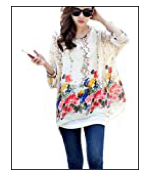

ASIN : B06XRZ8YWP
Brand: Fakeface
Title: womens floral bohemian chiffon tops batwing sleeve loose blouse beach cover 
Euclidean similarity with the query image : 1.1267562810603025


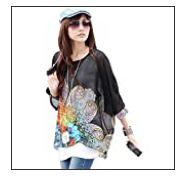

ASIN : B0167Z1H8K
Brand: welcomeuni 1340
Title: welcomeuni lady black batwing sleeve chiffon shirt bohemian tops oversized blouse 
Euclidean similarity with the query image : 1.128787165498047


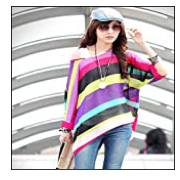

ASIN : B01J0T2FFE
Brand: morecome
Title: morecome women batwing sleeve chiffon shirt bohemian stripe oversized blouse 
Euclidean similarity with the query image : 1.1294988462825784


In [9]:
# This method performs same action as the bag of words model. Only difference is that the converted vectors has tf-idf value instead of the count
def tfidfModel(doc_index, num_of_similar_prod):
    
    pairwise_dist = pairwise_distances(tfidf_word_matrix,tfidf_word_matrix[doc_index])

    sorted_indices_of_distance = np.argsort(pairwise_dist.flatten())[0:num_of_similar_prod]
    p_distance  = np.sort(pairwise_dist.flatten())[0:num_of_similar_prod]
    
    for i in range(len(sorted_indices_of_distance)):
        get_result(data['medium_image_url'].loc[sorted_indices_of_distance[i]])
        print('ASIN :',data['asin'].loc[sorted_indices_of_distance[i]])
        print ('Brand:', data['brand'].loc[sorted_indices_of_distance[i]])
        print ('Title:', data['title'].loc[sorted_indices_of_distance[i]])
        print ('Euclidean similarity with the query image :', p_distance[i])
        print('='*60)
    
tfidfModel(12566, 20)

  <ul>
    <li><h3>Loading Word2Vec model</h3></li>
</ul>

In [25]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


In [26]:
# Loading pre-trained google's word2vec model using google news data
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=1500000)

In [27]:
# vocab = contains all the words that are there in google w2v model

vocab = model.index_to_key
def build_vec(text, doc_id, m_name):
    

    featureVector = np.zeros((300,), dtype="float32")
   
    nwords = 0
    
    for word in text.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  tfidf_vectorizer.vocabulary_:
                featureVector = np.add(featureVector, tfidf_word_matrix[doc_id, tfidf_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVector = np.add(featureVector, model[word])
    if(nwords>0):
        featureVector = np.divide(featureVec, nwords)
    return featureVector

  <ul>
    <li><h3>Average Word2Vec model</h3></li>
</ul>

In [28]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_vec(i, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)


In [30]:
import joblib
joblib.dump(w2v_title, 'avg_w2v.pkl')

['avg_w2v.pkl']

In [10]:
w2v_title = joblib.load('avg_w2v.pkl')

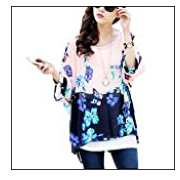

Title : bao core womens floral semi sheer batwing loose blouse bohemian oversized shirt 
ASIN : B012SXRBVC
Brand : Bao Core
euclidean distance from input : 0.0


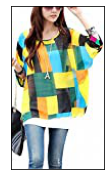

Title : jltph women batwing chiffon shirt bohemian floral semi sheer loose blouse tunic tops 
ASIN : B01HOBRHH6
Brand : JLTPH
euclidean distance from input : 0.61944455


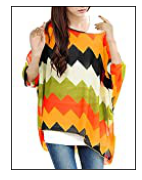

Title : jltph ladies batwing chiffon shirt bohemian semi sheer loose floral blouse tunic tops 
ASIN : B01HOCYP7U
Brand : JLTPH
euclidean distance from input : 0.6287079


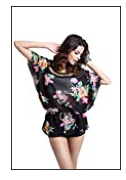

Title : katuo womens bohemian balck floral chiffon shirt batwing sleeve plus size 
ASIN : B010EPSIQI
Brand : KATUO
euclidean distance from input : 0.63986135


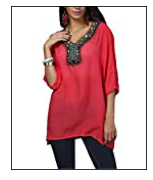

Title : kafeimali womens bohemian embroidered loose tops semi sheer shirt mini dress 
ASIN : B00ZTQGELY
Brand : Kafeimali
euclidean distance from input : 0.6463942


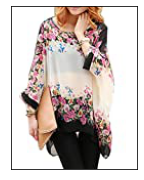

Title : eshion womens bohemian style oversized dolman sleeve floral chiffon shirt tops 
ASIN : B06XD6Z9D2
Brand : eshion
euclidean distance from input : 0.65537494


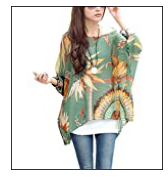

Title : yiyayo womens bohemian style floral batwing sleeve chiffon beach loose shirt 
ASIN : B01EX8IRLS
Brand : YiYaYo
euclidean distance from input : 0.6657814


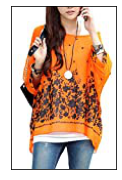

Title : evas eye womens batwing dolman chiffon bohemian boho loose blouse oversize shirt 
ASIN : B015R5WTOW
Brand : Eva's Eye
euclidean distance from input : 0.67127156


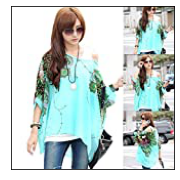

Title : lookatool womens bohemia floral batwing chiffon loose tshirt blouse top 
ASIN : B012UZW92Y
Brand : Lookatool
euclidean distance from input : 0.6758424


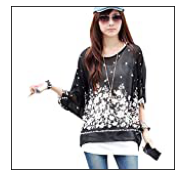

Title : bestpriceam womens bohemian style chiffon blouse loose shirt  4255 xl black 
ASIN : B010D427V2
Brand : bestpriceam
euclidean distance from input : 0.6766143


In [11]:
def avg_w2v_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        get_result(data['medium_image_url'].loc[df_indices[i]])
        print('Title :',data['title'].loc[df_indices[i]])
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

avg_w2v_model(12566, 10)
#931
#12566
# in the give heat map, each cell contains the euclidean distance between words i, j

  <ul>
    <li><h3>TF-IDF weighted Word2Vec model</h3></li>
</ul>

In [ ]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [12]:
w2v_title_weight = joblib.load('tfidf_wordvec_model.pkl')

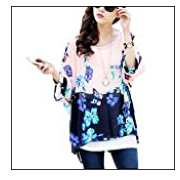

Title : bao core womens floral semi sheer batwing loose blouse bohemian oversized shirt 
ASIN : B012SXRBVC
Brand : Bao Core
euclidean distance from input : 0.0


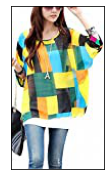

Title : jltph women batwing chiffon shirt bohemian floral semi sheer loose blouse tunic tops 
ASIN : B01HOBRHH6
Brand : JLTPH
euclidean distance from input : 0.2054466


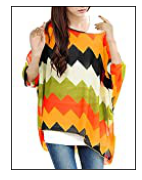

Title : jltph ladies batwing chiffon shirt bohemian semi sheer loose floral blouse tunic tops 
ASIN : B01HOCYP7U
Brand : JLTPH
euclidean distance from input : 0.20646949


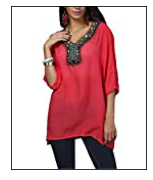

Title : kafeimali womens bohemian embroidered loose tops semi sheer shirt mini dress 
ASIN : B00ZTQGELY
Brand : Kafeimali
euclidean distance from input : 0.22022937


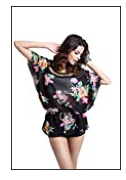

Title : katuo womens bohemian balck floral chiffon shirt batwing sleeve plus size 
ASIN : B010EPSIQI
Brand : KATUO
euclidean distance from input : 0.22179197


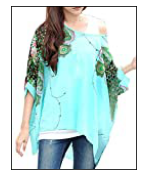

Title : womens oversized batwing sleeve chiffon shirt bohemian tops blouse medium bgreen 
ASIN : B010NJID6U
Brand : AM CLOTHES
euclidean distance from input : 0.22208476


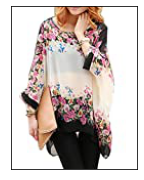

Title : eshion womens bohemian style oversized dolman sleeve floral chiffon shirt tops 
ASIN : B06XD6Z9D2
Brand : eshion
euclidean distance from input : 0.22873624


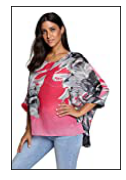

Title : nicetage bohemian floral chiffon blouse casual batwing blouse hippie semi sheer loose tops 
ASIN : B074M7BYBJ
Brand : Nicetage
euclidean distance from input : 0.22904706


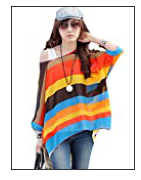

Title : buybox womens batwing dolman sleeve shirt bohemian tops oversized blouse 
ASIN : B012ND68EI
Brand : Buy-Box
euclidean distance from input : 0.22956201


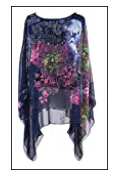

Title : ostale womens bohemian batwing sleeve loose tops flower chiffon blouse tee top shirt 
ASIN : B01DZT17AY
Brand : Ostale
euclidean distance from input : 0.23324941


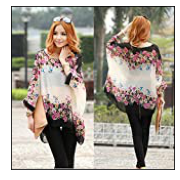

Title : sfy bohemian style women oversized dolman sleeve floral chiffon shirt blouse 
ASIN : B071191MFL
Brand : SoForYou
euclidean distance from input : 0.2344431


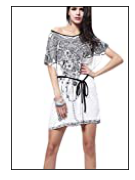

Title : bestal casual dress batwing dolman sleeve bohemian blouse plus size 
ASIN : B00PP7222W
Brand : Bestal
euclidean distance from input : 0.23586155


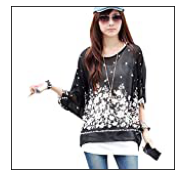

Title : bestpriceam womens bohemian style chiffon blouse loose shirt  4255 xl black 
ASIN : B010D427V2
Brand : bestpriceam
euclidean distance from input : 0.2361553


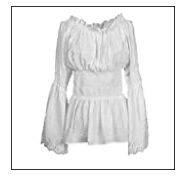

Title : amashz white lace cotton womens peasant shirt blouse retro vintage design semi sheer 
ASIN : B01D2EPVL8
Brand : Amashz
euclidean distance from input : 0.23781995


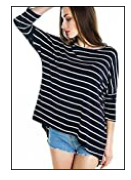

Title : urban coco womens basic striped loose blouse 34 sleeve tops hilow hem style 
ASIN : B0157YJT1Y
Brand : Urban CoCo
euclidean distance from input : 0.23993284


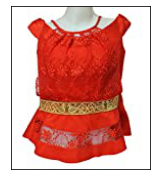

Title : red lao laos sleeveless blouse classic neckline floral lace tops size 38 sl38g 
ASIN : B074RH7GQF
Brand : Nanon
euclidean distance from input : 0.24071516


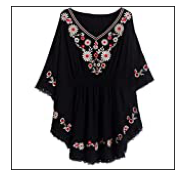

Title : ashir aley batwing style vintage flowers embroidered lace trim v neck bohemian dressy peasant tops mexican blouse 
ASIN : B071SHRMD3
Brand : Ashir Aley
euclidean distance from input : 0.24104334


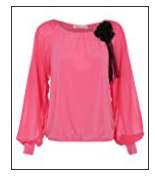

Title : krisp chiffon shoulder blouse semi sheer long sleeve detachable boho flower 
ASIN : B014T0DNW8
Brand : KRISP
euclidean distance from input : 0.24124742


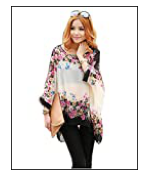

Title : women bohemian style topsoversized dolman sleeve floral chiffon shirt tops blouse 
ASIN : B071R4C865
Brand : Jingjing1
euclidean distance from input : 0.24176191


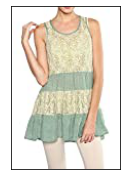

Title : areve ryu boho chic plus size green cream stripe tank babydoll lace xl 1xl 2xl 
ASIN : B06XKVZWCQ
Brand : A'reve by Ryu
euclidean distance from input : 0.24198778


In [13]:
def weighted_w2v_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        get_result(data['medium_image_url'].loc[df_indices[i]])
        print('Title :',data['title'].loc[df_indices[i]])
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(12566, 20)


<h2> Evaluating Models </h2>

In [10]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt


  <ul>
    <li><h3>Evaluating Bag of Words</h3></li>
</ul>

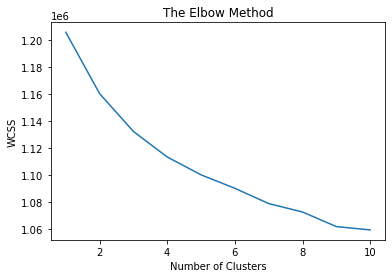

In [10]:
wcss=[]
for i in range(1,11):
    kmean=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmean.fit(word_matrix)
    wcss.append(kmean.inertia_)

plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [14]:
cluster = KMeans(n_clusters=4, random_state=10)
cluster_label = cluster.fit_predict(word_matrix)
print(len(cluster_label))

142013


In [15]:
silhouette_scr = silhouette_score(word_matrix, cluster_label)
print("Silhouette Score using Bag of Words vector representation:", silhouette_scr)


Silhouette Score using Bag of Words vector representation: 0.03165940513541597


  <ul>
    <li><h3>Evaluating TF-IDF</h3></li>
</ul>

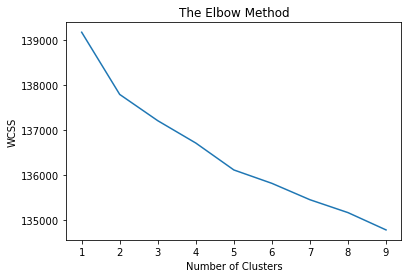

In [12]:
wcss=[]
for i in range(1,10):
    kmean=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmean.fit(tfidf_word_matrix)
    wcss.append(kmean.inertia_)

plt.plot(range(1,10),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [16]:
cluster = KMeans(n_clusters=4, random_state=10)
cluster_label = cluster.fit_predict(tfidf_word_matrix)
print(len(cluster_label))

142013


In [17]:
silhouette_scr = silhouette_score(tfidf_word_matrix, cluster_label)
print("Silhouette Score using TF-IDF vector representation:", silhouette_scr)


Silhouette Score using TF-IDF vector representation: 0.005454012167924226


  <ul>
    <li><h3>Evaluating Average Word2Vec</h3></li>
</ul>

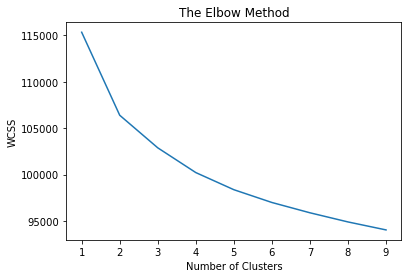

In [41]:
wcss=[]
for i in range(1,10):
    kmean=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmean.fit(w2v_title)
    wcss.append(kmean.inertia_)

plt.plot(range(1,10),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [42]:
cluster = KMeans(n_clusters=3, random_state=10)
cluster_label = cluster.fit_predict(w2v_title)
print(len(cluster_label))

142013


In [43]:
silhouette_scr = silhouette_score(w2v_title, cluster_label)
print("Silhouette Score using average word2vec vector representation:", silhouette_scr)


Silhouette Score using average word2vec vector representation: 0.02906784


  <ul>
    <li><h3>Evaluating TF-IDF weighted Word2Vec</h3></li>
</ul>

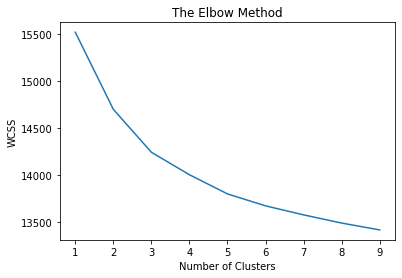

In [18]:
wcss=[]
for i in range(1,10):
    kmean=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmean.fit(w2v_title_weight)
    wcss.append(kmean.inertia_)

plt.plot(range(1,10),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [21]:
cluster = KMeans(n_clusters=3, random_state=10)
cluster_label = cluster.fit_predict(w2v_title_weight)
print(len(cluster_label))

142013


In [22]:
silhouette_scr = silhouette_score(w2v_title_weight, cluster_label)
print("Silhouette Score using TF-IDF weighted word2vec vector representation:", silhouette_scr)


Silhouette Score using TF-IDF weighted word2vec vector representation: 0.052411254
